<a href="https://colab.research.google.com/github/santhanambharathi2610/BMS/blob/main/BMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import datetime
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def load_data(battery):
  mat = loadmat('B0005.mat')
  print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  capacity_data = []

  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'discharge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      capacity = data[0][0]['Capacity'][0][0]
      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_load = data[0][0]['Current_load'][0][j]
        voltage_load = data[0][0]['Voltage_load'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                        voltage_measured, current_measured,
                        temperature_measured, current_load,
                        voltage_load, time])
      capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
      counter = counter + 1
  print(dataset[0])
  return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]
dataset, capacity = load_data('B0005')
pd.set_option('display.max_columns', 10)
print(dataset.head())
dataset.describe()
dataset.to_csv("TARP.csv")

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  1.856487          4.191492   
1      1                   24 2008-04-02 15:25:41  1.856487          4.190749   
2      1                   24 2008-04-02 15:25:41  1.856487          3.974871   
3      1                   24 2008-04-02 15:25:41  1.856487          3.951717   
4      1                   24 2008-04-02 15:25:41  1.856487          3.934352   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.004902             24.330034       -0.0006         0.000   0.000  
1         -0.001478             24.325993       -0.0006         4.206  16.781  
2         -2.012528             24.389085       -1.9982         3.062  35.703  
3         -2.

Text(0.5, 1.0, 'Discharge B0005')

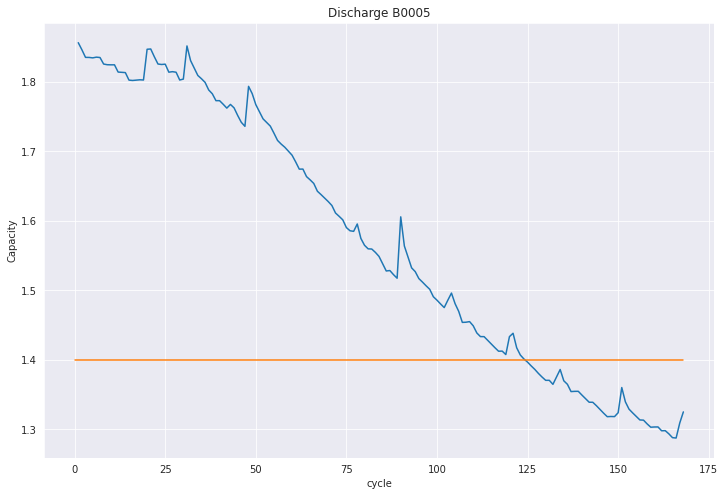

In [ ]:
plot_df = capacity.loc[(capacity['cycle']>=1),['cycle','capacity']]
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
plt.plot(plot_df['cycle'], plot_df['capacity'])
#Draw threshold
plt.plot([0.,len(capacity)], [1.4, 1.4])
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')

In [ ]:
C = dataset['capacity'][0]
soh = []
for i in range(len(dataset)):
  soh.append([dataset['capacity'][i] / C])
soh = pd.DataFrame(data=soh, columns=['SoH'])

attribs=['capacity', 'voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load', 'time']
train_dataset = dataset[attribs]
sc = MinMaxScaler(feature_range=(0,1))
train_dataset = sc.fit_transform(train_dataset)
print(train_dataset.shape)

print(soh.shape)

(50285, 7)
(50285, 1)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingRegressor


In [ ]:
// LINEAR REGRESSION

In [ ]:
x=train_dataset
y=soh

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=1/3,random_state=0)
pd.DataFrame(x_train)
pd.DataFrame(y_train)

,SoH
43698,0.710034
19761,0.873761
5202,0.977098
10036,0.952130
31441,0.783146
...,...
21243,0.854188
45891,0.712999
42613,0.721209
43567,0.712728


In [ ]:
from sklearn.linear_model import LinearRegression
regressor=LinearRegression()
regressor.fit(x,y)

LinearRegression()

In [ ]:
y_pred = regressor.predict(x_test)
y_pred

array([[0.96037443],
       [0.77209898],
       [0.94642052],
       ...,
       [0.76088789],
       [0.87947541],
       [0.89085121]])

In [ ]:
y_test

,SoH
8226,0.960374
35470,0.772099
12917,0.946421
37555,0.749418
48906,0.696726
...,...
14240,0.929886
33046,0.772128
34841,0.760888
19046,0.879475


In [ ]:
from sklearn.metrics import r2_score
MAE=metrics.mean_absolute_error(y_test,y_pred)
MSE=metrics.mean_squared_error(y_test,y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test,y_pred))
R_squared=r2_score(y_test,y_pred)*100
print("MAE:",MAE)
print("MSE:",MSE)
print("RMSE:",RMSE)
print("R squared value:", R_squared)


MAE: 1.0463067128029827e-16
MSE: 1.7269715687935753e-32
RMSE: 1.314142902729218e-16
R squared value: 100.0


In [ ]:
#SVR
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn import metrics
import numpy as np

x_train,x_test, y_train, y_test = train_test_split(x, y, test_size = 0.8, random_state = 0)

clf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
clf.fit(x_train,y_train)

pred=clf.predict(x_test)

MAE=metrics.mean_absolute_error(y_test,pred)
MSE=metrics.mean_squared_error(y_test,pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test,pred))
R_squared=r2_score(y_test,pred)*100

print("MAE:",MAE)
print("MSE:",MSE)
print("RMSE:", RMSE)
print("R squared value:", R_squared)


MAE: 0.05604023735212213
MSE: 0.003983307258631589
RMSE: 0.06311344752611435
R squared value: 58.688011350853266


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#KNN
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
import numpy as np

x_train,x_test, y_train, y_test = train_test_split(x, y, test_size = 0.8, random_state = 0)

clf = KNeighborsRegressor(n_neighbors=5)
clf.fit(x_train,y_train)

pred=clf.predict(x_test)

MAE=metrics.mean_absolute_error(y_test,pred)
MSE=metrics.mean_squared_error(y_test,pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test,pred))
R_squared=r2_score(y_test,pred)*100

print("MAE:",MAE)
print("MSE:",MSE)
print("RMSE:", RMSE)
print("R squared value:", R_squared)


MAE: 0.0013231985968986358
MSE: 3.857149171017677e-06
RMSE: 0.001963962619557123
R squared value: 99.95999643200362
